이번 강의에서는 교재 Example Example 6.5: Windy Gridworld를 구현합니다. 우선 문제를 잘 읽어 보세요. 
  - 성신여자대학교 AI융합학부 강화학습 수업을 위해 작성한 자료입니다. 2025년 8월 26일 초안을 작성하였고, 2025년 10월 3일 업데이트하였습니다. 
  - 코드는 2018년 작성한 코드를 바탕으로 Claude Pro를 이용해 변수명 등을 수정하였습니다. 

# 1. Exercise 6.5: Windy Gridworld 
설명을 잘 읽고, 문제를 정의합니다. 'Stochastic wind'는 다른 방식으로 정의해도 상관 없어요. 

Exercise 6.10: Stochastic Wind (programming) Re-solve the windy gridworld task with King’s moves, assuming that the e↵ect of the wind, if there is any, is stochastic, sometimes varying by 1 from the mean values given for each column. That is, a third of the time you move exactly according to these values, as in the previous exercise, but also a third of the time you move one cell above that, and another third of the time you move one cell below that. For example, if you are one cell to the right of the goal and you move left, then one-third of the time you move one cell above the goal, one-third of the time you move two cells above the goal, and one-third of the time you move to the goal.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


GRID_HEIGHT = 7
GRID_WIDTH = 10

# 바람의 세기(각 열에 대한 y축 이동)입니다.
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0] # (x=3,4,5는 1칸, x=6,7은 2칸, x=8은 1칸 위로 밀림)

# 시작 및 목표 상태입니다.
START_STATE = (3, 0) # (y, x)
GOAL_STATE = (3, 7)  # (y, x)

# 행동을 정의(dy, dx)해 줍니다. 예제의 4방향, 8방향, 8방향+정지 행동을 모두 구현해 봅니다.
# (y가 증가하면 아래로, y가 감소하면 위로)
# Up, Down, Left, Right
ACTIONS_4 = [(-1, 0), (1, 0), (0, -1), (0, 1)] 
# King's Moves: Up, Down, Left, Right, Up-Left, Up-Right, Down-Left, Down-Right
ACTIONS_8 = ACTIONS_4 + [(-1, -1), (-1, 1), (1, -1), (1, 1)]
# 8방향 + Stay
ACTIONS_9 = ACTIONS_8 + [(0, 0)]

# Sarsa 파라미터로 알고리즘을 비교하기 위해 다른 알고리즘에서도 동일하게 사용합니다.
ALPHA = 0.5
EPSILON = 0.1
GAMMA = 1.0 # Given discount factor입니다.

REWARD_PER_STEP = -1
REWARD_GOAL = 0

def env_step_stochastic_wind(state, action_idx, current_actions):
    """
    Stocasitc wind 문제에서의 바람을 구현합니다. 
    바람은 평균값에서 -1, 0, +1로 변동할 수 있습니다 (각각 1/3 확률).
    """
    y, x = state
    dy, dx = current_actions[action_idx]

    # 행동에 따른 다음 위치(바람 적용 전)이고,
    next_y_after_action = y + dy
    next_x_after_action = x + dx

    # 바람 적용 후 입니다.
    final_next_y = next_y_after_action
    final_next_x = next_x_after_action

    if 0 <= final_next_x < GRID_WIDTH: # 그리드 내의 x좌표일 때만 바람 적용합니다. 바람이 부는 위치가 있지요?
        mean_wind_effect = WIND[final_next_x]
        
        # 확률적으로 바람의 효과 결정(-1, 0, +1 변동)합니다.
        rand_val = np.random.rand()
        if rand_val < 1/3:                                      # 1/3 확률로 바람 효과가 평균보다 1 감소합니다.
            stochastic_wind_effect = mean_wind_effect - 1
        elif rand_val < 2/3:                                    # 1/3 확률로 바람 효과가 평균과 동일합니다.
            stochastic_wind_effect = mean_wind_effect
        else:                                                   # 1/3 확률로 바람 효과가 평균보다 1 증가합니다.
            stochastic_wind_effect = mean_wind_effect + 1
        
        final_next_y -= stochastic_wind_effect                  # 그림 그리는 게 조금 헷깔릴 수 있는데, 교재의 그림처럼 바람이 위로 분다는 것은 y 인덱스 감소시킵니다. 부호를 맞추는 건 본인의 알고리즘에 맞게 하면 돼요.

    # 경계 처리도 해 줍니다.
    final_next_y = max(0, min(final_next_y, GRID_HEIGHT - 1))
    final_next_x = max(0, min(final_next_x, GRID_WIDTH - 1))

    next_state = (final_next_y, final_next_x)

    reward = REWARD_PER_STEP
    if next_state == GOAL_STATE:
        reward = REWARD_GOAL       

    return next_state, reward

def plot_results(results, labels, title, x_limit=8000):
    plt.figure(figsize=(12, 6))
    
    for i, res in enumerate(results):
        cumulative_steps = np.cumsum(res)
        # x_limit을 넘지 않는 에피소드만 그리는데, 아마 그려보면 알겠지만 너무 긴 에피소드를 교재와 같은 그래프랑 다르게 안 예쁘게 나와서 추가합니다. 
        episodes_within_limit = np.sum(cumulative_steps <= x_limit)
        
        plt.plot(cumulative_steps[:episodes_within_limit], np.arange(1, episodes_within_limit + 1), label=labels[i])
    
    plt.xlabel('Time Steps (Total Steps)')
    plt.ylabel('Episodes')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xlim(0, x_limit)
    plt.show()

def plot_trajectory(Q, actions_set, start_state, goal_state, title="Optimal Trajectory"): # 최적 Q 값에 따른 에이전트의 움직임 궤적을 시각화합니다.
    plt.figure(figsize=(GRID_WIDTH, GRID_HEIGHT + 1.0))
    
    plt.imshow(np.zeros((GRID_HEIGHT, GRID_WIDTH)), cmap='bone_r', origin='upper', 
               extent=[-0.5, GRID_WIDTH-0.5, GRID_HEIGHT-0.5, -0.5])    # extent: [left, right, bottom, top]
    
    # 바람 화살표를 시각화합니다.
    for x in range(GRID_WIDTH):
        if WIND[x] > 0:
            plt.arrow(x, GRID_HEIGHT - 0.5, 0, -0.4 * WIND[x], color='blue', head_width=0.2, head_length=0.2, alpha=0.6)
            plt.text(x, GRID_HEIGHT + 0.2, str(WIND[x]), color='blue', ha='center', va='top', fontsize=10)

    plt.text(start_state[1], start_state[0], 'S', color='green', ha='center', va='center', fontsize=12, weight='bold')
    plt.text(goal_state[1], goal_state[0], 'G', color='red', ha='center', va='center', fontsize=12, weight='bold')
    plt.hlines(y=np.arange(-0.5, GRID_HEIGHT), xmin=-0.5, xmax=GRID_WIDTH-0.5, color='black', linewidth=0.5)
    plt.vlines(x=np.arange(-0.5, GRID_WIDTH), ymin=-0.5, ymax=GRID_HEIGHT-0.5, color='black', linewidth=0.5)
    plt.xticks([]) 
    plt.yticks([]) 
    
    path_x = [start_state[1]]
    path_y = [start_state[0]]

    max_steps = 1000 
    current_iter_state = START_STATE
    
    # 그냥 구현을 하면 무한 루프에 빠지기 쉽습니다. 이전에 방문했던 상태를 추적할 수 있도록 구현해 주어야 합니다. 이런 부분은 직접 코딩을 해 봐야 느껴 지겠지요?
    visited_states = set() 

    for step_count in range(max_steps): 
        if current_iter_state == GOAL_STATE:
            break
        if current_iter_state in visited_states: # 무한 루프 감지(같은 상태를 여러 번 방문하는 경우)해서 빠져나옵니다.
            # print(f"Trajectory stuck in a loop at state {current_iter_state} after {step_count} steps.") # 이건 디버깅할 때 썼던 로그입니다. 필요하면 켜서 보세요.
            break
        visited_states.add(current_iter_state)

        y, x = current_iter_state
        # 최적 정책 (가장 높은 Q 값)에 따라 행동 선택합니다.
        best_action_idx = np.argmax(Q[y, x, :])
        dy, dx = actions_set[best_action_idx]
        
        # 다음 상태 계산(바람 포함)하고,
        next_y_unwind = y + dy
        next_x_unwind = x + dx

        next_y_winded = next_y_unwind
        if 0 <= next_x_unwind < GRID_WIDTH:
            # 그림 그릴 때는 plot_trajectory에서는 결정론적 바람만 적용합니다. 실제 현상에서는 stochastic wind를 적용하지만, 궤적을 그릴 때는, 그러니까 보고서에 그래프를 그린다고 생각하면 결정론적 바람이 더 직관적이기 때문입니다.
            next_y_winded -= WIND[next_x_unwind]

        final_next_y = max(0, min(next_y_winded, GRID_HEIGHT - 1))
        final_next_x = max(0, min(next_x_unwind, GRID_WIDTH - 1))
        
        # 궤적을 선으로 그리기주어야 하므로,
        plt.plot([current_iter_state[1], final_next_x], [current_iter_state[0], final_next_y], 'r-o', markersize=3, linewidth=1)
        
        current_iter_state = (final_next_y, final_next_x)
        path_x.append(current_iter_state[1])
        path_y.append(current_iter_state[0])
    
    # 그리고 최종 궤적을 굵은 선으로 다시 그려 강조합니다.
    plt.plot(path_x, path_y, 'r-', linewidth=2, marker='o', markersize=4)

    plt.title(title)
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.show()

## 1. Sarsa (on-policy TD control) for estimating $Q\approx q_\ast$

100%|██████████| 8000/8000 [00:01<00:00, 7639.57it/s]


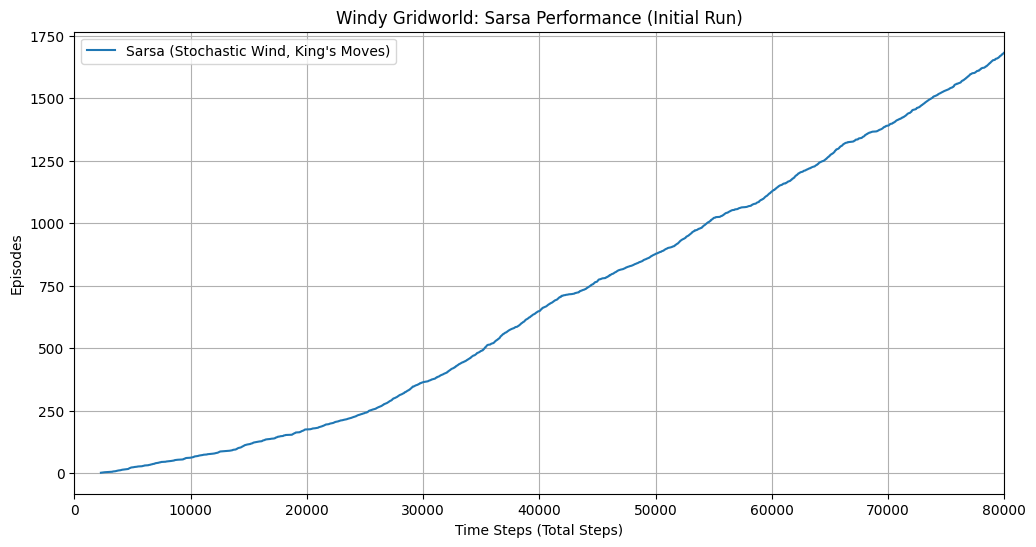


Optimal Trajectory with Sarsa (Stochastic Wind):


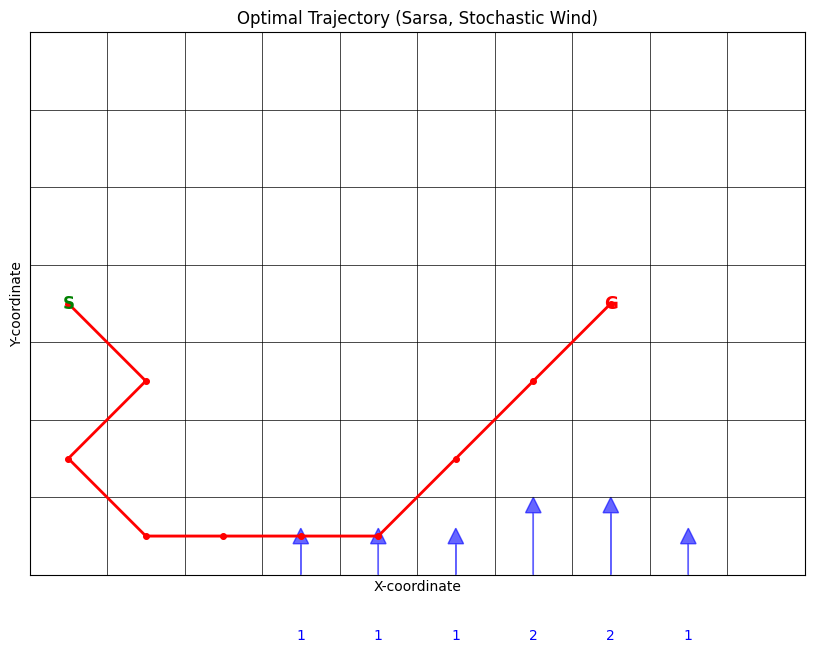

In [3]:
def sarsa_agent_stochastic_wind(num_episodes, actions_set):
    num_actions = len(actions_set)
    Q = np.zeros((GRID_HEIGHT, GRID_WIDTH, num_actions))
    episode_steps = []

    for episode in tqdm(range(num_episodes)):
        current_state = START_STATE
        steps = 0

        # epsilon-greedy 정책에 따라 초기 행동 선택합니다.
        if np.random.rand() < EPSILON:
            current_action_idx = np.random.randint(num_actions)
        else:
            current_action_idx = np.argmax(Q[current_state[0], current_state[1], :])

        while current_state != GOAL_STATE:
            steps += 1
            if steps > 5000: 
                break 
            
            next_state, reward = env_step_stochastic_wind(current_state, current_action_idx, actions_set)
            
            # 다음 상태에서 epsilon-greedy 정책에 따라 다음 행동 선택합니다. On-policy죠?
            if next_state == GOAL_STATE:
                next_action_idx = None 
            elif np.random.rand() < EPSILON:
                next_action_idx = np.random.randint(num_actions)
            else:
                next_action_idx = np.argmax(Q[next_state[0], next_state[1], :])

            # Sarsa 업데이트입니다. 교재랑 최대한 동일하게 변수명 등을 맞춰 주었으니 읽기 쉬울 거예요.
            old_q = Q[current_state[0], current_state[1], current_action_idx]
            target_q_prime = Q[next_state[0], next_state[1], next_action_idx] if next_state != GOAL_STATE else 0

            Q[current_state[0], current_state[1], current_action_idx] = old_q + ALPHA * (reward + GAMMA * target_q_prime - old_q)

            # 상태 및 행동 업데이트하고, 다음 스탭을 준비합니다.
            current_state = next_state
            current_action_idx = next_action_idx
            
            if next_action_idx is None and current_state == GOAL_STATE:
                break

        episode_steps.append(steps)
    
    return episode_steps, Q


NUM_EPISODES = 8000 # 혹시 결과가 잘 나오지 않는다면 optimal 궤적을 찾지 못한 것일 수 있으니, 에피소드를 늘려 보세요.
episode_steps_stochastic_8, Q_stochastic_8 = sarsa_agent_stochastic_wind(NUM_EPISODES, ACTIONS_8)

all_results_sarsa_initial = [episode_steps_stochastic_8]
all_labels_sarsa_initial = ['Sarsa (Stochastic Wind, King\'s Moves)']
plot_results(all_results_sarsa_initial, all_labels_sarsa_initial, 'Windy Gridworld: Sarsa Performance (Initial Run)', x_limit=NUM_EPISODES * 10)

print("\nOptimal Trajectory with Sarsa (Stochastic Wind):")
plot_trajectory(Q_stochastic_8, ACTIONS_8, START_STATE, GOAL_STATE, "Optimal Trajectory (Sarsa, Stochastic Wind)")

# 2. Q-learning, for estimating $Q \approx q_\ast$

Q-learning으로 문제를 풀어 봅시다. 6장에서 사용한 알고리즘을 다른 문제에 적용해 보면서 익숙해 지면 됩니다. 

100%|██████████| 8000/8000 [00:01<00:00, 4000.26it/s]


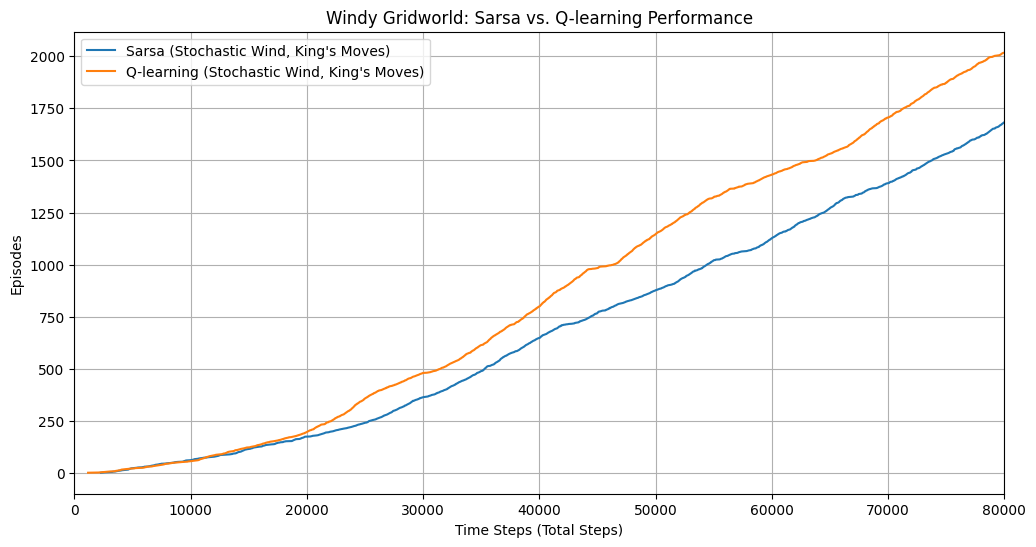


Optimal Trajectory with Q-learning (Stochastic Wind):


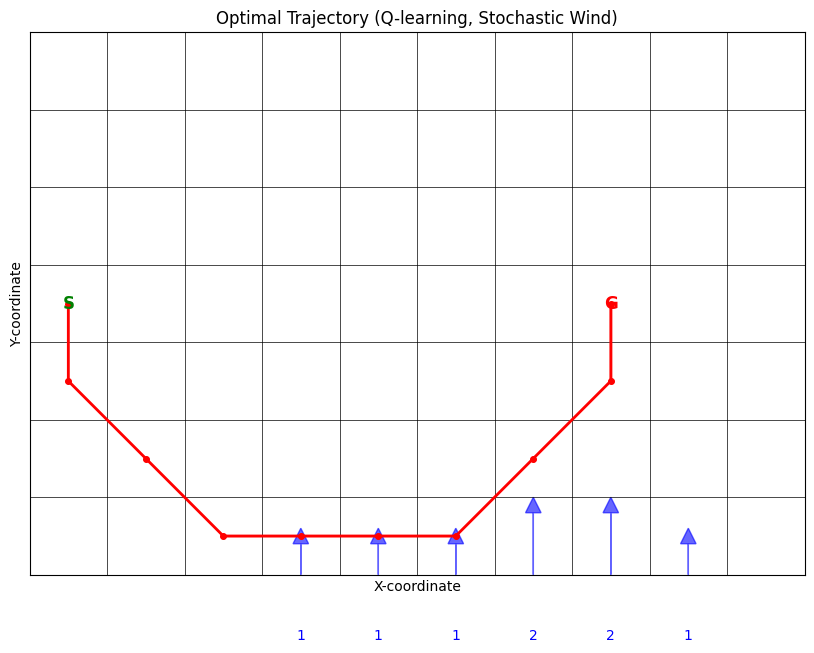

In [6]:
def q_learning_agent(num_episodes, actions_set):
    num_actions = len(actions_set)
    Q = np.zeros((GRID_HEIGHT, GRID_WIDTH, num_actions))
    episode_steps = []

    for episode in tqdm(range(num_episodes)):
        current_state = START_STATE
        steps = 0

        while current_state != GOAL_STATE:
            steps += 1
            if steps > 5000: 
                break 

            # Sarsa와 똑같이 epsilon-greedy 정책에 따라 현재 행동 선택합니다. 이게 결국 behavior policy가 됩니다.
            if np.random.rand() < EPSILON:
                current_action_idx = np.random.randint(num_actions)
            else:
                current_action_idx = np.argmax(Q[current_state[0], current_state[1], :])

            next_state, reward = env_step_stochastic_wind(current_state, current_action_idx, actions_set)

            # Q-learning 업데이트입니다. 업데이트는 target policy (greedy policy)를 따릅니다. target과 behavior가 다르지요? Off-policy입니다.
            old_q = Q[current_state[0], current_state[1], current_action_idx]
            
            # 다음 상태에서 가장 높은 Q 값 선택합니다. 구현을 위해 목표 상태에 도달하면 다음 Q 값은 0이 됨
            max_next_q = np.max(Q[next_state[0], next_state[1], :]) if next_state != GOAL_STATE else 0

            Q[current_state[0], current_state[1], current_action_idx] = old_q + ALPHA * (reward + GAMMA * max_next_q - old_q)

            current_state = next_state
            
            if current_state == GOAL_STATE:
                break

        episode_steps.append(steps)
    
    return episode_steps, Q

NUM_EPISODES = 8000
episode_steps_q_learning, Q_q_learning = q_learning_agent(NUM_EPISODES, ACTIONS_8)

all_results_q_comp = [episode_steps_stochastic_8, episode_steps_q_learning]
all_labels_q_comp = ['Sarsa (Stochastic Wind, King\'s Moves)', 'Q-learning (Stochastic Wind, King\'s Moves)']
plot_results(all_results_q_comp, all_labels_q_comp, 'Windy Gridworld: Sarsa vs. Q-learning Performance', x_limit=NUM_EPISODES * 10)

print("\nOptimal Trajectory with Q-learning (Stochastic Wind):")
plot_trajectory(Q_q_learning, ACTIONS_8, START_STATE, GOAL_STATE, "Optimal Trajectory (Q-learning, Stochastic Wind)")

## 4. Double Q-learning, for estimating $𝑄_1≈𝑄_2≈𝑞_∗$

In [ ]:
def double_q_learning_agent(num_episodes, actions_set):
    num_actions = len(actions_set)
    QA = np.zeros((GRID_HEIGHT, GRID_WIDTH, num_actions))
    QB = np.zeros((GRID_HEIGHT, GRID_WIDTH, num_actions))
    episode_steps = []

    for episode in tqdm(range(num_episodes)):
        current_state = START_STATE
        steps = 0

        while current_state != GOAL_STATE:
            steps += 1
            if steps > 5000: 
                break 

            # Sutton & Barto 책의 pseudo code를 보면 QA+QB의 합을 사용하여 행동을 선택합니다.
            avg_Q = (QA[current_state[0], current_state[1], :] + QB[current_state[0], current_state[1], :]) / 2.0
            
            if np.random.rand() < EPSILON:
                current_action_idx = np.random.randint(num_actions)
            else:
                current_action_idx = np.argmax(avg_Q)

            next_state, reward = env_step_stochastic_wind(current_state, current_action_idx, actions_set)

            # 두 Q-테이블 중 하나를 무작위로 선택하여 업데이트합니다.
            if np.random.rand() < 0.5:
                # QA로 다음 상태에서 가장 좋은 행동 A'을 선택하면,
                best_action_for_QA = np.argmax(QA[next_state[0], next_state[1], :])
                # QB로 선택된 A'의 Q값 추정하고,
                target_q_prime = QB[next_state[0], next_state[1], best_action_for_QA] if next_state != GOAL_STATE else 0
                
                QA[current_state[0], current_state[1], current_action_idx] += ALPHA * (reward + GAMMA * target_q_prime - QA[current_state[0], current_state[1], current_action_idx])
            else: 
                # QB로 다음 상태에서 가장 좋은 행동 A'을 선택하면,
                best_action_for_QB = np.argmax(QB[next_state[0], next_state[1], :])
                # QA로 선택된 A'의 Q값 추정
                target_q_prime = QA[next_state[0], next_state[1], best_action_for_QB] if next_state != GOAL_STATE else 0
                
                QB[current_state[0], current_state[1], current_action_idx] += ALPHA * (reward + GAMMA * target_q_prime - QB[current_state[0], current_state[1], current_action_idx])

            # 상태 업데이트
            current_state = next_state
            
            if current_state == GOAL_STATE:
                break

        episode_steps.append(steps)
    
    # 두 Q-테이블의 평균을 최종 정책 평가에 사용
    final_Q = (QA + QB) / 2.0
    return episode_steps, final_Q

# Double Q-learning 학습 실행
NUM_EPISODES = 8000
episode_steps_double_q_learning, Q_double_q_learning = double_q_learning_agent(NUM_EPISODES, ACTIONS_8)

# 결과 플로팅 (Sarsa with Stochastic Wind와 비교)
all_results_dq_comp = [episode_steps_stochastic_8, episode_steps_double_q_learning]
all_labels_dq_comp = ['Sarsa (Stochastic Wind, King\'s Moves)', 'Double Q-learning (Stochastic Wind, King\'s Moves)']
plot_results(all_results_dq_comp, all_labels_dq_comp, 'Windy Gridworld: Sarsa vs. Double Q-learning Performance', x_limit=NUM_EPISODES * 10)

# 최적 궤적 시각화
print("\nOptimal Trajectory with Double Q-learning (Stochastic Wind):")
plot_trajectory(Q_double_q_learning, ACTIONS_8, START_STATE, GOAL_STATE, "Optimal Trajectory (Double Q-learning, Stochastic Wind)")

In [ ]:
# 셀 5: 2-step Sarsa 구현 (Stochastic Wind, King's Moves)

print("--- Cell 5: 2-step Sarsa (Stochastic Wind, King's Moves) ---")

def two_step_sarsa_agent(num_episodes, actions_set):
    """
    2-step Sarsa 에이전트를 사용하여 확률적 바람이 부는 Windy Gridworld를 학습시킵니다.
    """
    num_actions = len(actions_set)
    Q = np.zeros((GRID_HEIGHT, GRID_WIDTH, num_actions))
    episode_steps = []

    for episode in tqdm(range(num_episodes)):
        current_state = START_STATE
        steps = 0
        
        # S, A 선택 (S_0, A_0)
        if np.random.rand() < EPSILON:
            S0_action_idx = np.random.randint(num_actions)
        else:
            S0_action_idx = np.argmax(Q[current_state[0], current_state[1], :])

        while current_state != GOAL_STATE:
            steps += 1
            if steps > 5000: 
                break 
            
            # S0, A0 -> R1, S1 (current_state, S0_action_idx)
            next_state_s1, reward_r1 = env_step_stochastic_wind(current_state, S0_action_idx, actions_set)

            # S1에서 A1 선택 (S_1, A_1) - 입실론-탐욕 정책
            if next_state_s1 == GOAL_STATE:
                S1_action_idx = None
            elif np.random.rand() < EPSILON:
                S1_action_idx = np.random.randint(num_actions)
            else:
                S1_action_idx = np.argmax(Q[next_state_s1[0], next_state_s1[1], :])
            
            # S1, A1 -> R2, S2 (next_state_s1, S1_action_idx)
            # S1_action_idx가 None이면 (S1이 목표상태이면), S2와 R2는 의미없음
            if next_state_s1 == GOAL_STATE:
                target_q_prime = 0 # 목표 상태에 도달했으므로
                
                # Q(S0, A0) 업데이트 (1-step TD)
                Q[current_state[0], current_state[1], S0_action_idx] += ALPHA * (reward_r1 + GAMMA * target_q_prime - Q[current_state[0], current_state[1], S0_action_idx])
                
                current_state = next_state_s1 # 목표 상태로 이동
                break # 에피소드 종료
            
            next_state_s2, reward_r2 = env_step_stochastic_wind(next_state_s1, S1_action_idx, actions_set)
            
            # S2에서 A2 선택 (S_2, A_2) - 입실론-탐욕 정책
            if next_state_s2 == GOAL_STATE:
                S2_action_idx = None
            elif np.random.rand() < EPSILON:
                S2_action_idx = np.random.randint(num_actions)
            else:
                S2_action_idx = np.argmax(Q[next_state_s2[0], next_state_s2[1], :])

            # 2-step Sarsa 업데이트
            # G_t = R_{t+1} + gamma * R_{t+2} + gamma^2 * Q(S_{t+2}, A_{t+2})
            
            # Q(S_{t+2}, A_{t+2}) 값 계산 (S2가 목표 상태면 0)
            Q_S2_A2 = Q[next_state_s2[0], next_state_s2[1], S2_action_idx] if next_state_s2 != GOAL_STATE else 0

            target = reward_r1 + GAMMA * reward_r2 + (GAMMA**2) * Q_S2_A2
            
            Q[current_state[0], current_state[1], S0_action_idx] += ALPHA * (target - Q[current_state[0], current_state[1], S0_action_idx])

            # 다음 스텝으로 상태 및 행동 이동
            current_state = next_state_s1
            S0_action_idx = S1_action_idx # S_0 <- S_1, A_0 <- A_1
            
            # Q-learning과 다르게 A0가 업데이트되기 위해 S0, A0, R1, S1, A1, R2, S2, A2까지 필요함.
            # 이 로직은 Q(St, At)를 업데이트하기 위해 St, At, R_t+1, S_t+1, A_t+1, R_t+2, S_t+2, A_t+2가 필요함을 의미합니다.
            # 루프의 첫 부분에서 St, At를 가져오고, 그 다음 스텝들에서 다음 정보들을 가져와 업데이트합니다.
            # 여기서는 S0, A0가 현재 Q값 업데이트의 기준이 되고, 다음 스텝에서는 S1, A1이 새로운 S0, A0가 됩니다.
            if current_state == GOAL_STATE:
                break # A1이 목표 상태로 이어졌으면 종료

        episode_steps.append(steps)
    
    return episode_steps, Q

# 2-step Sarsa 학습 실행
NUM_EPISODES = 8000
episode_steps_2step_sarsa, Q_2step_sarsa = two_step_sarsa_agent(NUM_EPISODES, ACTIONS_8)

# 결과 플로팅 (Sarsa with Stochastic Wind와 비교)
all_results_2s_comp = [episode_steps_stochastic_8, episode_steps_2step_sarsa]
all_labels_2s_comp = ['Sarsa (Stochastic Wind, King\'s Moves)', '2-step Sarsa (Stochastic Wind, King\'s Moves)']
plot_results(all_results_2s_comp, all_labels_2s_comp, 'Windy Gridworld: Sarsa vs. 2-step Sarsa Performance', x_limit=NUM_EPISODES * 10)

# 최적 궤적 시각화
print("\nOptimal Trajectory with 2-step Sarsa (Stochastic Wind):")
plot_trajectory(Q_2step_sarsa, ACTIONS_8, START_STATE, GOAL_STATE, "Optimal Trajectory (2-step Sarsa, Stochastic Wind)")

In [ ]:
# 셀 6: Off-policy 2-step TD Control (Sutton & Barto Example 6.9, n-step Q-learning의 2-step 버전)

print("--- Cell 6: Off-policy 2-step TD Control (n-step Q-learning like) ---")

def off_policy_two_step_td_agent(num_episodes, actions_set):
    """
    Off-policy 2-step TD Control 에이전트(n-step Q-learning의 2-step 버전)를 사용하여
    확률적 바람이 부는 Windy Gridworld를 학습시킵니다.
    행동은 입실론-탐욕 정책(behavior policy)으로 선택하고,
    업데이트는 n-step Q-learning처럼 다음 상태의 최적 행동(target policy)을 기반으로 합니다.
    """
    num_actions = len(actions_set)
    Q = np.zeros((GRID_HEIGHT, GRID_WIDTH, num_actions))
    episode_steps = []

    for episode in tqdm(range(num_episodes)):
        current_state = START_STATE
        steps = 0
        
        # 에피소드의 경험을 저장할 버퍼 (S, A, R)
        # 2-step이므로 최소 2개의 (S, A, R) 쌍이 필요합니다.
        # S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1}, R_{t+2}, S_{t+2} 가 필요
        # Q(S_t, A_t) 업데이트를 위해: S_t, A_t, R_{t+1}, R_{t+2}, Q(S_{t+2}, A^*_{t+2})
        
        # Sutton & Barto n-step Q-learning 의사코드에 따라 구현
        states_buffer = [current_state]
        actions_buffer = [] # actions_buffer[k]는 S_k에서 취한 행동 A_k
        rewards_buffer = [] # rewards_buffer[k]는 A_k 이후 받은 R_{k+1}
        
        # 첫 번째 행동 A_0 선택 (입실론-탐욕)
        if np.random.rand() < EPSILON:
            action_0_idx = np.random.randint(num_actions)
        else:
            action_0_idx = np.argmax(Q[current_state[0], current_state[1], :])
        
        actions_buffer.append(action_0_idx)

        T = float('inf') # 에피소드 종료 시간
        t = 0 # 현재 스텝 인덱스 (0부터 시작)

        while True:
            steps += 1
            if steps > 5000:
                break

            if t < T: # 에피소드가 아직 끝나지 않았다면
                # S_t, A_t를 가지고 R_{t+1}, S_{t+1} 얻기
                next_state_stoch, reward_stoch = env_step_stochastic_wind(states_buffer[t], actions_buffer[t], actions_set)
                
                rewards_buffer.append(reward_stoch)
                states_buffer.append(next_state_stoch)

                if next_state_stoch == GOAL_STATE:
                    T = t + 1 # 목표 상태에 도달하면 T 설정
                else:
                    # S_{t+1}에서 A_{t+1} 선택 (입실론-탐욕)
                    if np.random.rand() < EPSILON:
                        next_action_idx = np.random.randint(num_actions)
                    else:
                        next_action_idx = np.argmax(Q[next_state_stoch[0], next_state_stoch[1], :])
                    actions_buffer.append(next_action_idx)
            
            # tau는 업데이트할 상태의 인덱스 (Stau, Atau)
            # 여기서는 n=2 이므로 tau = t - 1
            # 업데이트는 t가 n-1 이상일 때 시작 (여기선 t >= 1)
            tau = t - 1 

            if tau >= 0: # 2-step 업데이트에 필요한 정보가 모두 모였을 때
                G = 0.0 # Return 계산
                
                # R_{tau+1}
                G += rewards_buffer[tau] 
                
                # R_{tau+2}
                if tau + 1 < T: # R_{tau+2} (rewards_buffer[tau+1]) 가 유효한 경우
                    G += GAMMA * rewards_buffer[tau+1]
                    
                # gamma^2 * max_a Q(S_{tau+2}, a)
                if tau + 2 < T: # S_{tau+2} (states_buffer[tau+2]) 가 유효한 경우
                    S_tau_plus_2 = states_buffer[tau+2]
                    max_q_s_tau_plus_2 = np.max(Q[S_tau_plus_2[0], S_tau_tau_plus_2[1], :])
                    G += (GAMMA**2) * max_q_s_tau_plus_2
                elif tau + 2 == T: # S_{tau+2}가 목표 상태인 경우
                    # 목표 상태에 도달했으므로 Q 값은 0
                    pass # G에 아무것도 더하지 않음 (Q 값 0)
                
                # Q-값 업데이트
                S_tau = states_buffer[tau]
                A_tau = actions_buffer[tau]
                Q[S_tau[0], S_tau[1], A_tau] += ALPHA * (G - Q[S_tau[0], S_tau[1], A_tau])

            if tau == T - 1: # 에피소드가 끝났을 때 모든 버퍼를 소진
                break

            t += 1
            # 에피소드 스텝 카운트는 실제 환경 스텝 수 (t)를 기반으로 합니다.
            # 여기서는 'steps' 변수가 이 역할을 수행합니다.
            if states_buffer[-1] == GOAL_STATE:
                break
        
        episode_steps.append(steps)
        if states_buffer[-1] == GOAL_STATE: # 최종 상태가 목표 상태이면 정상 종료
            pass
        else: # 루프가 5000 스텝 때문에 종료된 경우
            pass
    
    return episode_steps, Q

# Off-policy 2-step TD 학습 실행
NUM_EPISODES = 8000
episode_steps_off_policy_2step, Q_off_policy_2step = off_policy_two_step_td_agent(NUM_EPISODES, ACTIONS_8)

# 결과 플로팅 (Sarsa with Stochastic Wind와 비교)
all_results_ops_comp = [episode_steps_stochastic_8, episode_steps_off_policy_2step]
all_labels_ops_comp = ['Sarsa (Stochastic Wind, King\'s Moves)', 'Off-policy 2-step TD (Stochastic Wind, King\'s Moves)']
plot_results(all_results_ops_comp, all_labels_ops_comp, 'Windy Gridworld: Sarsa vs. Off-policy 2-step TD Performance', x_limit=NUM_EPISODES * 10)

# 최적 궤적 시각화
print("\nOptimal Trajectory with Off-policy 2-step TD (Stochastic Wind):")
plot_trajectory(Q_off_policy_2step, ACTIONS_8, START_STATE, GOAL_STATE, "Optimal Trajectory (Off-policy 2-step TD, Stochastic Wind)")

# 6-1. Off-policy 2-step Sarsa for estimating $Q\approx q_\ast$

Off-policy 2-step TD: 100%|██████████| 8000/8000 [04:11<00:00, 31.77it/s] 


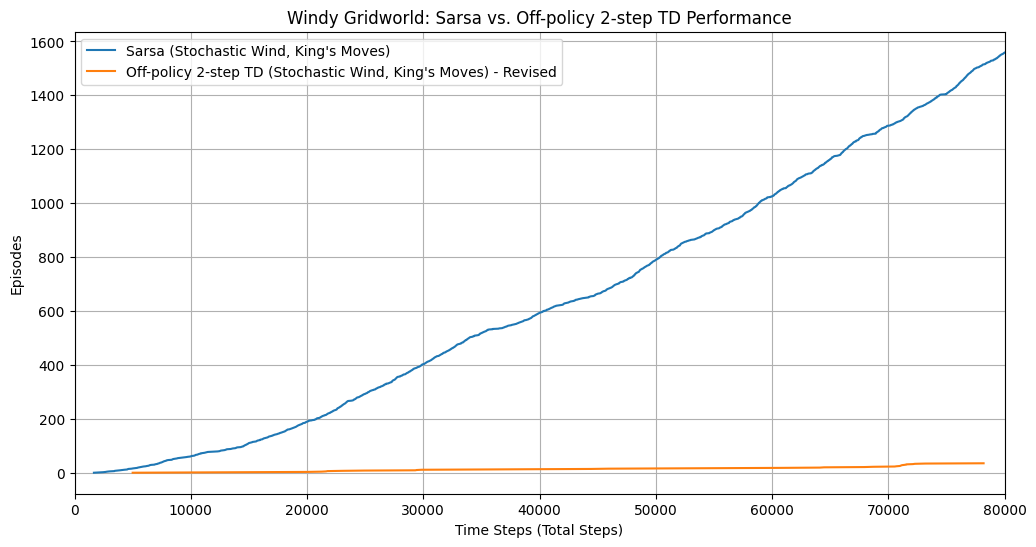


Optimal Trajectory with Off-policy 2-step TD (Stochastic Wind) - Revised:


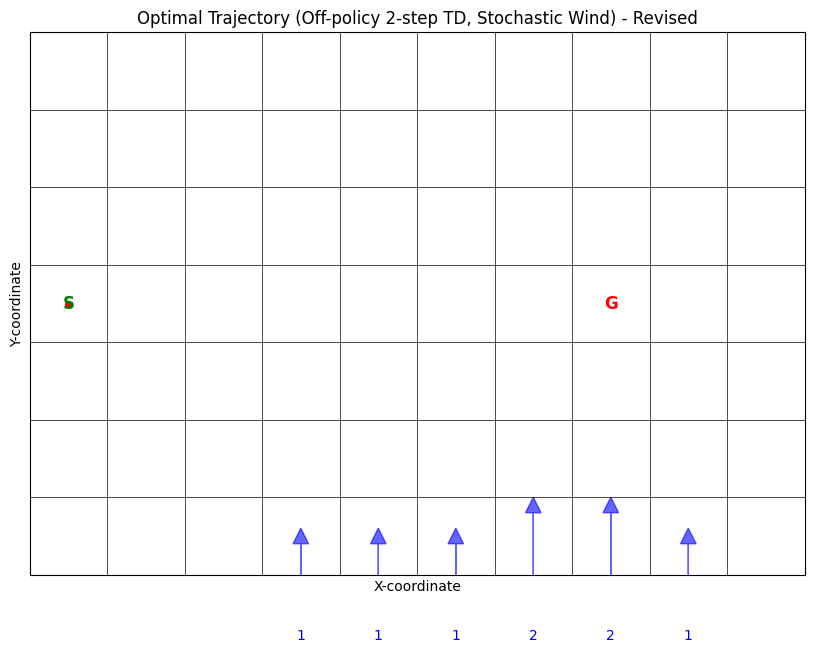

In [4]:
# Off-policy 2-step TD Control (Stochastic Wind, King's Moves)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----- 환경 설정 -----
GRID_HEIGHT, GRID_WIDTH = 7, 10
START_STATE = (3, 0)
GOAL_STATE  = (3, 7)

# King’s moves (8방향)
ACTIONS_8 = [(-1, 0), (1, 0), (0, -1), (0, 1),  # 상하좌우
             (-1, -1), (-1, 1), (1, -1), (1, 1)] # 대각선

# stochastic wind step 함수 (교수님 코드에 있던 것 재사용)
def env_step_stochastic_wind(state, action_idx, actions_set):
    r, c = state
    dr, dc = actions_set[action_idx]
    nr, nc = r + dr, c + dc

    # 바람 효과 (stochastic)
    wind = np.random.choice([0, 1, 2], p=[0.1, 0.8, 0.1])  
    nr -= wind  

    # 경계 처리
    nr = max(0, min(GRID_HEIGHT - 1, nr))
    nc = max(0, min(GRID_WIDTH - 1, nc))

    next_state = (nr, nc)
    reward = -1
    return next_state, reward

# epsilon-greedy 정책 (확률 포함 버전)
def epsilon_greedy_with_probs(Q, state, eps, n_actions):
    r, c = state
    if np.random.rand() < eps:
        a = np.random.randint(n_actions)
    else:
        max_a = np.argwhere(Q[r, c] == np.max(Q[r, c])).flatten()
        a = np.random.choice(max_a)
    probs = np.ones(n_actions) * (eps / n_actions)
    probs[a] += 1.0 - eps
    return a, probs


# ----- Off-policy 2-step TD Control -----
def off_policy_two_step_td_control(num_episodes, actions_set):
    n_actions = len(actions_set)
    Q = np.zeros((GRID_HEIGHT, GRID_WIDTH, n_actions))
    episode_steps = []
    n = 2   # 2-step
    max_steps = 5000  # 무한 루프 방지용

    for ep in tqdm(range(num_episodes), desc="Off-policy 2-step TD"):
        states, actions, rewards = [], [], []
        s = START_STATE
        a, _ = epsilon_greedy_with_probs(Q, s, EPSILON, n_actions)

        states.append(s)
        actions.append(a)

        T = float("inf")
        t = -1
        steps = 0

        while True:
            t += 1
            steps += 1
            if steps > max_steps:
                break

            if t < T:
                s_t = states[t]
                a_t = actions[t]
                s_tp1, r_tp1 = env_step_stochastic_wind(s_t, a_t, actions_set)

                rewards.append(r_tp1)
                states.append(s_tp1)

                if s_tp1 == GOAL_STATE:
                    T = t + 1
                else:
                    a_tp1, _ = epsilon_greedy_with_probs(Q, s_tp1, EPSILON, n_actions)
                    actions.append(a_tp1)

            tau = t - n + 1
            if tau >= 0:
                G = sum([(GAMMA ** i) * rewards[tau + i] for i in range(min(n, T - tau))])
                if tau + n < T:
                    s_tau_n = states[tau + n]
                    G += (GAMMA ** n) * np.max(Q[s_tau_n[0], s_tau_n[1], :])

                s_tau = states[tau]
                a_tau = actions[tau]
                Q[s_tau[0], s_tau[1], a_tau] += ALPHA * (G - Q[s_tau[0], s_tau[1], a_tau])

            if tau == T - 1:
                break

        episode_steps.append(steps)

    return episode_steps, Q


# ----- 하이퍼파라미터 -----
EPSILON = 0.1
ALPHA = 0.5
GAMMA = 1.0
NUM_EPISODES = 8000

# ----- 학습 실행 -----
episode_steps_off_policy_2step, Q_off_policy_2step = off_policy_two_step_td_control(NUM_EPISODES, ACTIONS_8)

# ----- 결과 플로팅 (교수님 기존 스타일과 동일) -----
all_results_ops_comp = [episode_steps_stochastic_8, episode_steps_off_policy_2step]
all_labels_ops_comp = [
    "Sarsa (Stochastic Wind, King's Moves)",
    "Off-policy 2-step TD (Stochastic Wind, King's Moves) - Revised"
]
plot_results(all_results_ops_comp, all_labels_ops_comp,
             "Windy Gridworld: Sarsa vs. Off-policy 2-step TD Performance",
             x_limit=NUM_EPISODES * 10)

# 최적 궤적 시각화
print("\nOptimal Trajectory with Off-policy 2-step TD (Stochastic Wind) - Revised:")
plot_trajectory(Q_off_policy_2step, ACTIONS_8, START_STATE, GOAL_STATE,
                "Optimal Trajectory (Off-policy 2-step TD, Stochastic Wind) - Revised")

# 6-2. Off-policy 2-step Sarsa for estimating $Q\approx q_\ast$

위의 6-1 코드와의 차이를 살펴 보세요. 

In [1]:
def _greedy_action(Q, s):
    y, x = s
    q = Q[y, x, :]
    max_as = np.argwhere(q == np.max(q)).flatten()
    return int(np.random.choice(max_as))

def _epsilon_greedy_with_probs(Q, s, epsilon, n_actions):
    y, x = s
    q = Q[y, x, :]
    max_as = np.argwhere(q == np.max(q)).flatten()
    m = len(max_as)
    probs = np.full(n_actions, epsilon / n_actions, dtype=float)
    probs[max_as] += (1.0 - epsilon) / m
    a = int(np.random.choice(np.arange(n_actions), p=probs))
    return a, probs

def two_step_offpolicy_td_control(num_episodes, actions_set):
    """
    Off-policy 2-step TD control with importance sampling.
    behavior policy b: ε-greedy wrt Q
    target   policy π: greedy wrt Q (deterministic)
    """
    n = 2
    n_actions = len(actions_set)
    Q = np.zeros((GRID_HEIGHT, GRID_WIDTH, n_actions), dtype=float)
    episode_step_counts = []
    max_steps = 5000  # 무한 루프 방지

    for ep in tqdm(range(num_episodes), desc="Off-policy 2-step TD"):
        states, actions, rewards = [], [], []

        # 초기 상태/행동 (behavior: ε-greedy)
        s0 = START_STATE
        a0, _ = _epsilon_greedy_with_probs(Q, s0, EPSILON, n_actions)
        states.append(s0)      # S_0
        actions.append(a0)     # A_0

        T = float('inf')
        t = -1
        steps_this_episode = 0

        while True:
            t += 1
            steps_this_episode += 1
            if steps_this_episode > max_steps:
                # 너무 길어지면 종료
                break

            # 아직 종료 전이면 한 스텝 진행하여 R_{t+1}, S_{t+1} 확보
            if t < T:
                s_t = states[t]
                a_t = actions[t]
                s_tp1, r_tp1 = env_step_stochastic_wind(s_t, a_t, actions_set)
                rewards.append(r_tp1)     # R_{t+1}
                states.append(s_tp1)      # S_{t+1}

                if s_tp1 == GOAL_STATE:
                    T = t + 1
                else:
                    a_tp1, _ = _epsilon_greedy_with_probs(Q, s_tp1, EPSILON, n_actions)
                    actions.append(a_tp1)  # A_{t+1} (behavior)

            # 업데이트 인덱스 τ = t - n + 1 (n=2 → τ = t-1)
            tau = t - n + 1

            if tau >= 0:
                # 2-step return G_τ = R_{τ+1} + γ R_{τ+2} + γ^2 Q(S_{τ+2}, π(S_{τ+2}))
                G = 0.0
                # R_{τ+1}
                G += rewards[tau]
                # γ * R_{τ+2}
                if tau + 1 < T:
                    G += GAMMA * rewards[tau + 1]
                # γ^2 * 부트스트랩 항
                if tau + 2 < T:
                    s_tpn = states[tau + 2]
                    a_tpn = _greedy_action(Q, s_tpn)  # π: greedy
                    G += (GAMMA ** 2) * Q[s_tpn[0], s_tpn[1], a_tpn]

                # 중요도 비율 ρ_{τ+1 : min(τ+2, T-1)}
                # π는 결정적 greedy, b는 ε-greedy
                rho = 1.0
                upper = int(min(tau + n, T - 1))
                for k in range(tau + 1, upper + 1):
                    s_k = states[k]
                    # 행동 버퍼에 반드시 존재하도록 구성되어 있으나, 방어적으로 처리
                    a_k = actions[k] if k < len(actions) else _greedy_action(Q, s_k)
                    # π(a|s): greedy면 1, 아니면 0
                    pi_prob = 1.0 if a_k == _greedy_action(Q, s_k) else 0.0
                    # b(a|s): ε-greedy 확률을 재계산
                    _, b_probs = _epsilon_greedy_with_probs(Q, s_k, EPSILON, n_actions)
                    b_prob = b_probs[a_k]
                    if b_prob <= 0.0:
                        rho = 0.0
                        break
                    rho *= (pi_prob / b_prob)
                    if rho == 0.0:
                        break

                # Q(S_τ, A_τ) 업데이트
                s_tau = states[tau]
                a_tau = actions[tau]
                Q[s_tau[0], s_tau[1], a_tau] += ALPHA * rho * (G - Q[s_tau[0], s_tau[1], a_tau])

            # 모든 필요 업데이트가 끝났으면 종료
            if tau == T - 1:
                break

        episode_step_counts.append(steps_this_episode)

    return episode_step_counts, Q

# 학습 실행 예시
NUM_EPISODES = 20000
episode_steps_off2, Q_off2 = two_step_offpolicy_td_control(NUM_EPISODES, ACTIONS_8)

# 기존과 동일한 방식으로 시각화 호출
all_results_ops_comp = [episode_steps_stochastic_8, episode_steps_off2]
all_labels_ops_comp  = ["Sarsa (Stochastic Wind, King's Moves)",
                        "Off-policy 2-step TD (Stochastic Wind, King's Moves) — IS"]
plot_results(all_results_ops_comp, all_labels_ops_comp,
             "Windy Gridworld: Sarsa vs. Off-policy 2-step TD Performance",
             x_limit=NUM_EPISODES * 10)

print("\nOptimal Trajectory with Off-policy 2-step TD (Greedy):")
plot_trajectory(Q_off2, ACTIONS_8, START_STATE, GOAL_STATE, "Optimal Trajectory (Off-policy 2-step TD, Greedy)")

NameError: name 'ACTIONS_8' is not defined